In [1]:
library(tidyverse) # metapackage of all tidyverse packages
suppressMessages(library(caret))
options(width=50)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")
.... = NA

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.3          ✔ dplyr   1.0.1     
✔ tidyr   1.1.1          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "voicegender"

<img src="https://i.imgur.com/cCErK0Z.png" width=280 style="float:right;margin:50px;margin-right:0px;margin-top:0px"/>


# 1. Signals

A signal is a sequence of measurements, called _samples_, at (ir)regular time intervals

- samples $x_t, t=1,2,\ldots, T$ (also $\{x_t\}_{t=1}^T$)
- we usually show a signal as a line graph, such as the one to the right


```
 (0.8208, 0.8014, 0.7556, 0.6903, 0.6903, 0.5819, 
 0.5167, 0.5,  0.5778, 0.7472, 0.9306, 1.1028, 
 1.2583, 1.35, 1.3611, 1.3181,  1.3417, 1.4194, 
 1.5431, 1.2861, 0.7167, 0.5708, 0.6875, 1.0625,  
 1.0861, 0.9944, 0.8347, 0.7806, 0.6806, 0.7014, 
 0.8111, 1.0069,  0.9861, 0.9056, 0.8806, 0.9083, 
 0.9306, 0.9486, 0.9847, 1.0861,  1.175, 1.1861, 
 1.2167, 1.3181, 1.3319, 1.3319, 0.9333, 0.9403, 
 0.9403, 1.3236, 1.4708, 1.4708, 1.2708, 1.0153, 
 1.0153, 0.8889, 0.6944, 0.6944, 0.6764, 0.7069, 
 0.7194, 0.6764, 0.7125, 0.7778,  0.8486, 0.9208, 
 1.0125, 1.1597, 1.3278, 1.3375, 1.2167, 1.1986, 
 1.4, 1.5458, 1.3028, 0.8583, 0.6653, 0.875, 
 1.0625, 1.0403, 1.0403, 0.8819, 0.8611, 0.8611, 
 0.65, 0.6694, 0.6694, 0.9069, 0.9625,  0.9792, 
 0.9069, 0.9139, 0.9694, 0.9958, 1.0403, 1.0417, 
 1.0528,  1.2792, 1.3681, 1.4097, 1.2958, 1.1292, 
 0.9875, 0.8889, 1.0319, 1.2722, 1.4153, 1.4208, 
 1.2611, 1.0681, 0.8806, 0.7958, 0.7472,  0.7208)
```




<img src="https://i.imgur.com/EYFjtu3.png" style="float:right;margin:50px;margin-right:0px" width=300 />
     
# 2. Features

One way to detect events or classify signals is to recognize and count specific patterns in the signal (analogous to words in emotion word lists)

- The problem is: Which patterns?
    
Good patterns are mostly not easy to recognize. Hand tweaking ‘discovered’ the pattern in the right graph

But even if we now 'good' patterns, there are still problems:

- time shift, time dilation (time stretching), amplitude change (amplitude stretching)
- Therefore: individual samples $x_t$ can not be used as features 
- We need time invariant features



<img src="https://i.imgur.com/Yrllubw.png" width=300 style="float:right;margin:50px;margin-left:0px;width:300px" />


## 2.1 Time invariant features

Two classes of features have time invariant / stretch invariant properties:

1. Distribution / Histogram features
2. Spectral features



### 2.1.1 Histogram features

- mean, sd, variance, min, max, skewness, kurtosis, range, number of modes, etc.
- auto-correlation, power, entropy
- comparisons 1st half vs 2nd half of segment, 1st quarter to 2nd quarter, etc.




### 2.1.2 Spectral features

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Light_dispersion_conceptual_waves.gif/330px-Light_dispersion_conceptual_waves.gif" width=300 style="float:right;margin:50px;margin-left:0px;width:300px" />


Spectral analysis decomposes signal into sine waves with different wave lengths, just like a prisma decomposes white light into light of different wavelengths. 

Instead of talking about wavelengths, we usually talk about frequencies, which is immaterial because wavelength = 1/frequency. So we decompose the signal into sine waves of different frequencies.

See [Jez Swanson's Fourier page](https://www.jezzamon.com/fourier/index.html) for an interactive explanation.

- How? With multiple linear regression on sine and cosine waves
- Regression coefficients ($\beta_k$ for sin, $\alpha_k$ for cosine) provide time invariant **power spectrum**: 
- Normally done with computationally efficient *Fast Fourier Transform* (FFT)
- Features that are derived from from spectrum
  - Power at specific frequencies/bands:
    
      $Pow_{1:3} = \beta_1^2+\beta_2^2+\beta_3^2 + \alpha_1^2+\alpha_2^2+\alpha_3^2$
        
      $Pow_{k:m} = \beta_k^2+\cdots+\beta_{m}^2+\alpha_k^2+\cdots+\alpha_{m}^2$
      
  - Phases $\phi_k = \arctan(\beta_k / \alpha_k)$, which we will not discuss here.

- More advanced features are *short time Fourier transform* (STFT) and wavelets


In R you should use the function `spectrum()`, but to drive the principles home lets use `lm()`:


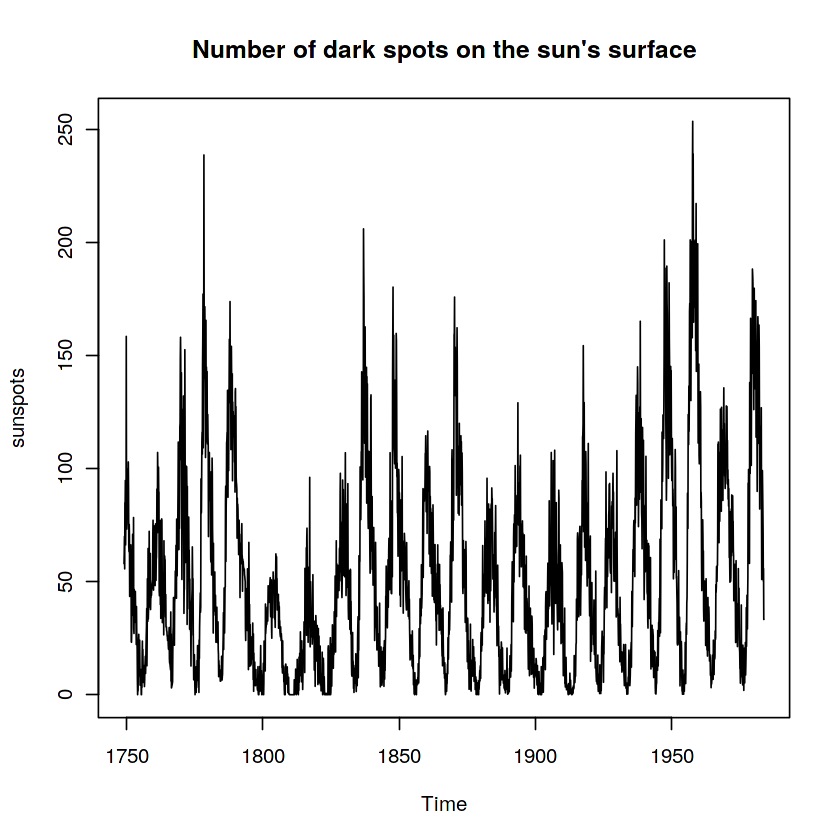

In [2]:
# Famous time function: Sunspots
plot(sunspots, main="Number of dark spots on the sun's surface")

We'll do a regression on sine and cosine waves of frequencies $\omega_k$ that correspond to 

- 1 full wave in the entire observed time interval, 
- 2 full waves in the entire interval
- 3 full waves, and
- 4 full waves

Hence, our regression model is

$$\begin{align*}\text{sunspots}_t = \beta_0 &+ \beta_1 \sin(1\cdot 2\pi t) + \beta_2 \sin(2\cdot 2\pi t)+ \beta_3 \sin(3\cdot 2\pi t) + \beta_4 \sin(4\cdot 2\pi t) \\ & + \alpha_1 \cos(1\cdot 2\pi t) + \alpha_2 \cos(2\cdot 2\pi t) + \alpha_3 \cos(3\cdot 2\pi t) + \alpha_4 \cos(4\cdot 2\pi t)  + \varepsilon_t \end{align*}$$

The periodogram is then calculated as

$$\text{Power}(\omega_k) = \alpha_k^2 + \beta_k^2,$$

and the power in spectral bands 1:2 and 3:4 are computed

$$\text{Power}[(1\cdot 2\pi/T, 2\cdot 2\pi/T)] = \sum_{k=1}^2\text{Power}(\omega_k), \qquad \text{Power}[(3\cdot 2\pi/T, 4\cdot 2\pi/T)] = \sum_{k=3}^4\text{Power}(\omega_k)$$

In R:

In [3]:
t = time(sunspots)
t = (t-min(t)) / (max(t) - min(t)) # normalize time

# regression to obtain first 3 spectral frequencies
fit = lm(sunspots ~ sin(1*2*pi*t) + cos(1*2*pi*t) # one full wave
         + sin(2*2*pi*t) + cos(2*2*pi*t) # two full waves
         + sin(3*2*pi*t) + cos(3*2*pi*t) # three full waves
         + sin(4*2*pi*t) + cos(4*2*pi*t) # four full waves
        )

coefficients = coef(fit)[-1] # drop intercept 
print(coefficients, digits=4)


sin(1 * 2 * pi * t) cos(1 * 2 * pi * t) 
             -4.351              12.084 
sin(2 * 2 * pi * t) cos(2 * 2 * pi * t) 
             -8.186              11.281 
sin(3 * 2 * pi * t) cos(3 * 2 * pi * t) 
              3.725              -8.668 
sin(4 * 2 * pi * t) cos(4 * 2 * pi * t) 
             -5.631              -9.583 


From the coefficients we can compute the power in the different powerbands:

In [7]:
alpha_k = coefficients[2*1:4 - 1] # odd coefficients are alphas
beta_k  = coefficients[2*1:4]     # even coefficients are alphas

# Power at frequencies k ('periodogram')
Power_k = alpha_k^2 + beta_k^2

# Power in frequency "bands"
Pow_band = c(Power_band_12 = sum(Power_k[1:2]), Power_band_34 = sum(Power_k[3:4]))
print(Pow_band)

sin(1 * 2 * pi * t) sin(2 * 2 * pi * t) 
          164.96220           194.27406 
sin(3 * 2 * pi * t) sin(4 * 2 * pi * t) 
           89.00651           123.53985

This is a very inefficient way of computing the spectrum. A much faster way uses the Fast Fourier Transform (FFT). The function `spectrum` uses it (by default). It computes the regression coefficients for all frequencies of the form $\omega_k = k\cdot 2\pi/T$, where $k = 1, 2, 3, \ldots, T/2$:

In [8]:
# The function spectrum() does this extremely fast for all 
# frequencies k = 1, 2, 3, ..., T/2. 

s = spectrum(sunspots, plot=FALSE)
glimpse(s[c('freq','spec')])


List of 2
 $ freq: num [1:1440] 0.00417 0.00833 0.0125 0.01667 0.02083 ...
 $ spec: num [1:1440] 6774 5103 13408 9593 618 ...


The numbers in `freq` are the frequencies; the numbers in `spec` are the powers at corresponding frequencies (`spec` from "spectrum", another word often used for "power"; in fact the official term is *power spectral density*, go figure...).

*Note*: `spectrum()` uses a different scale than the regression approach, which is why they are not equal. A more barebones implementation of the fast Fourier transform is available as <code>fft()</code> in R.



----------

<img src="https://i.imgur.com/TPo5QtI.png" width=300 style="float: right; margin: 50px; margin-right: 0px" />

# 3. Voice data for gender recognizer

In this example the above mentioned type of features are used. For this practical you won't have to compute these features yourself, but now you will at least have some understanding of what they mean.



We want to recognize gender based on speech sample

- 21 Features: all spectral (mean frequency, sd, Q25, Q75, flatness, kurtosis, …)
- Target: gender (male/female)

(Pardon the simplification of gender into just male/female; it's for sake of simplicity.)


In [101]:
voice = read.csv('../input/voicegender/voice.csv')
glimpse(voice)

Rows: 3,168
Columns: 21
$ meanfreq <dbl> 0.05978098, 0.06600874, 0.0773…
$ sd       <dbl> 0.06424127, 0.06731003, 0.0838…
$ median   <dbl> 0.03202691, 0.04022873, 0.0367…
$ Q25      <dbl> 0.015071489, 0.019413867, 0.00…
$ Q75      <dbl> 0.09019344, 0.09266619, 0.1319…
$ IQR      <dbl> 0.07512195, 0.07325232, 0.1232…
$ skew     <dbl> 12.8634618, 22.4232854, 30.757…
$ kurt     <dbl> 274.402906, 634.613855, 1024.9…
$ sp.ent   <dbl> 0.8933694, 0.8921932, 0.846389…
$ sfm      <dbl> 0.4919178, 0.5137238, 0.478905…
$ mode     <dbl> 0.00000000, 0.00000000, 0.0000…
$ centroid <dbl> 0.05978098, 0.06600874, 0.0773…
$ meanfun  <dbl> 0.08427911, 0.10793655, 0.0987…
$ minfun   <dbl> 0.01570167, 0.01582591, 0.0156…
$ maxfun   <dbl> 0.2758621, 0.2500000, 0.271186…
$ meandom  <dbl> 0.007812500, 0.009014423, 0.00…
$ mindom   <dbl> 0.0078125, 0.0078125, 0.007812…
$ maxdom   <dbl> 0.0078125, 0.0546875, 0.015625…
$ dfrange  <dbl> 0.0000000, 0.0468750, 0.007812…
$ modindx  <dbl> 0.00000000, 0.05263158, 0.04

These variables are defined by the acoustic properties:

<div style="display:flex; flex-direction: row; flex-wrap: nowrap; align-items: stretch; width:100%;">
    <div style="display:inline-block;width:45%;">
        <ul>
<li>meanfreq: mean frequency (in kHz)
<li>sd: standard deviation of frequency
<li>median: median frequency (in kHz)
<li>Q25: first quantile (in kHz)
<li>Q75: third quantile (in kHz)
<li>IQR: interquantile range (in kHz)
<li>skew: skewness (see note in specprop description)
<li>kurt: kurtosis (see note in specprop description)
<li>sp.ent: spectral entropy
<li>sfm: spectral flatness
<li>mode: mode frequency
<li>centroid: frequency centroid (see specprop)
<li>peakf: peak frequency (frequency with highest energy)
<li>meanfun: average of fundamental frequency measured across acoustic signal
        </ul>
    </div>
    <div style="display:inline-block;width:45%;">
        <ul>
<li>minfun: minimum fundamental frequency measured across acoustic signal
<li>maxfun: maximum fundamental frequency measured across acoustic signal
<li>meandom: average of dominant frequency measured across acoustic signal
<li>mindom: minimum of dominant frequency measured across acoustic signal
<li>maxdom: maximum of dominant frequency measured across acoustic signal
<li>dfrange: range of dominant frequency measured across acoustic signal
<li>modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
<li>label: male or female
        </ul>
    </div>



## Three Fundamental Questions 

<span style=font-size:16pt>🧠</span> Get in the habit to *always* ask the following three questions about your data set as well as possible

- What is the data origin (representative for which population?)
- What are candidate machine learning algorithms? 
- What is the Bayes bound? 




<div style="float:right; margin:50px; margin-right: 0px; width: 300px; margin-top: 0px">
<img src="https://paper-attachments.dropbox.com/s_B163C45492A31F9E0113E9055212B280A18E0A64A89D22DB28771233544A6924_1567765926504_image.png" />
<div>Human performance (n=100, german). C,Y,A,S=child, young, adult, senior, F,M = female, male. From (Metze et al., 2007).</div>
</div>


### Answers to the Fundamental Questions

- Data origin (representative for which population?)
    - Full information is given [here](https://data.world/ml-research/gender-recognition-by-voice) 
    - What’s the population for which the trained classifier will work as validated? 
    
    Higher educated people
    
    
- What are candidate machine learning algorithms? (Ch 4)
    - Logistic regression, Linear Disciminate Analysis

- What’s the Bayes bound? ≥ Human performance
    - How well can human’s do it? 
    - Always do a literature search indeed! 
    - *([Metze et al., 2007. ICASSP’07, vol. 4](https://www.researchgate.net/publication/224711638_Comparison_of_Four_Approaches_to_Age_and_Gender_Recognition_for_Telephone_Applications#fullTextFileContent))* <br>
        Acc: 99%, <br>
        Sens: 99.6%, <br>
        Spec: 98.3% <br>
        (gender recognition for human faces: ≈ 11.6%)

The human performance is very good. We can predict quite accurate if a men or a woman is talking. 



# 4. Data Pre-processing

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Use the `caret` package to remove redundant variables. Think of

- variables with near zero variation,
- highly correlated variables,
- multicollinearity (hidden correlation, see the [counting syllables](https://www.kaggle.com/code/datasniffer/syllable-counting-model-exercise-with-caret) exercise).

Store the cleaned up dataframe in the variable `clean_voice`.

In [148]:
# variables with near zero variation
nearZeroVar(voice, saveMetrics= TRUE)
#everything is false, so we can kept it in 


# highly correlated variables

voice_cor <-  cor(voice[,1:20])
highly_cor <- findCorrelation(voice_cor, cutoff = .9) #so let´s take them out 
voice_c <- voice[,-c(highly_cor)]


# multicollinearity

comboo <- findLinearCombos(voice_c[,1:16])
comboo #have to delet column 

voice <- voice_c[,-5]
# yes it is with 16 variable 


$linearCombos
$linearCombos[[1]]
[1] 5 3 4


$remove
[1] 5

# 5. Model fitting

You will use and evaluate 4 different classifiers to recognize the gender of the speaker: 

1. Logistic regression
2. LDA
3. QDA
4. k-NN

You will do this with the `caret` package which makes it very little work to fit these four. 

Afterwards you will make a visualization of a comparison of their performance.


# 5.1 Logistic regression model

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Fit and evaluate as in ISLR §4.6 Lab with the `glm()` function.

- Use `label` as the dependent variable ('target')
- Use `Q25`, `median`, and `Q75` as predictors 
    - Why would you expect these to work? What's the difference between male 
      and female voices? How are these differences reflected in this set of 
      features? 
- Store your model in the variable `fitglm`

In [149]:
## Logistic Regression for voice-gender recognition

#recode the gender
voice_1 <-  voice %>%
mutate(label = ifelse(label == "female",1,0)) 

fit_glm <- glm(label ~ Q25 + median + Q75, data = voice, family = binomial)
fit_glm


Call:  glm(formula = label ~ Q25 + median + Q75, family = binomial, 
    data = voice)

Coefficients:
(Intercept)          Q25       median  
      -5.71       -37.81       -10.50  
        Q75  
      57.74  

Degrees of Freedom: 3167 Total (i.e. Null);  3164 Residual
Null Deviance:	    4390 
Residual Deviance: 2910 	AIC: 2920

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Use the `predict()` function to predict the conditional probabilities for `label = "male"`, given the values of `Q25`, `median`, and `Q75`. 

- To do so you must set the argument `type="resp"`. 
- Store the predicted probabilities in the variable `pred_prob`

In [103]:
# Compute predicted probabilities for each label
pred_prob = predict(fit_glm,newdata=voice, type= "response")

# Check predictions
head(pred_prob)

1          2          3          4 
0.80414217 0.82052485 0.23366350 0.27239275 
         5          6 
0.13036401 0.07123611

We will turn the predicted probabilities into the predicted labels `male` or `female` using the threshold of 0.5, which would be the Bayes optimal decision bound if the model is the best possible:

In [104]:
# Convert predicted probabilities into label predictions
pred = ifelse(pred_prob > 0.5, 'male', 'female')
pred = as.factor(pred)

# Check correctness
head(pred)

1      2      3      4      5      6 
  male   male female female female female 
Levels: female male


#### Performance evaluation

To evaluate the performance we can use the predicted labels by computing the ***confusion matrix*** and the ***accuracy***:

In [105]:
# Confusion matrix:
truth = voice$label
cat("Confusion matrix\n")
print(table(pred, truth))

# Accuracy
cat("\nAccuracy: ", mean(pred == truth))

Confusion matrix
        truth
pred     female male
  female    263 1465
  male     1321  119

Accuracy:  0.1205808

*Note: The accurcy should be around 0.88. Otherwise check your model fitting command.*

# 5.1.1 Cross-validated logistic regression with `caret`

The `caret` package makes lets us do this quicker, and provides options to include cross-validation automatically for us. To fit the same model as you did above, we can do

In [151]:
## Logistic Regression for voice-gender recognition

# caret requires a cross-validation settings 'trainControl' object
# for evaluating a fitted model
trcntr = trainControl('cv', number = 2, p=0.8)

# the train() function is the fitting function 
fit_glm = caret::train(label ~ Q25 + median + Q75, data=voice, method="glm", trControl = trcntr)
fit_glm

Generalized Linear Model 

3168 samples
   3 predictor
   2 classes: 'female', 'male' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1584, 1584 
Resampling results:

  Accuracy  Kappa
  0.878     0.757


<span style=font-size:16pt>🧠</span> What do you think about the performance accuracy? 

- Is it high enough? 

The performance is not that good. You can see that at the Confusion matrix. A lot of predictions are wrong. Also the RMSE and the Rsquared

- Should we be able to improve? (*Hint: What was our lower bound of the Bayes bound again?*)

Yes we could. For example we can add some predictors. 

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Now use `carot::train()` to make the model more flexible by adding features to the model formula and store it in `fit_glm`:

In [143]:
formula <- label ~ Q25 + median + Q75

# Use the 'train()' function to create a logistic regression model
fit_glm <- train(form = formula, data = voice, method = "glm", family = binomial)
fit_glm

Generalized Linear Model 

3168 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1584, 1584 
Resampling results:

  RMSE  Rsquared  MAE  
  0.39  0.392     0.309


<span style=font-size:16pt>🧠</span> How is the performance accuracy now? 

- Is it (much) better? 
It is much better. But I think something did go wrong in the other model. 

- How does it compare to our Bayes lower bound?
- Should we be able to still improve, or do we have no hopes of improvement? 

If the model is performing worse than a known lower bound, this may caused by
- a  model that is still too inflexible (i.e., there may be non-linearities), 
- bad features (information missing?),
- too little data


# 5.2 Linear Discriminant Analysis

To run an LDA instead of the logistic regression above we only have to modify the `method` argument in the call to `caret::train` above:

In [121]:
## LDA for voice-gender recognition

fit_lda = caret::train(label ~ Q25 + median + Q75, data=voice, method="lda", trControl = trcntr)
fit_lda

Linear Discriminant Analysis 

3168 samples
   3 predictor
   2 classes: 'female', 'male' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1584, 1584 
Resampling results:

  Accuracy   Kappa    
  0.8781566  0.7563131


<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Change the above code to use the same set of features you logistic regression utilized.

# 5.3 Quadratic Discriminant Analysis

QDA can also be fitted by a simple change of the `method` argument to `"qda"`. 

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Do so for the model with the features you included above. 

- How is QDA different from LDA? 



- Which is more flexible?

QDA is generally more flexible than LDA because it does not impose the assumption of equal covariance matrices.

<span style=font-size:16pt>🧠</span> Is there an improvement or a detoriation over LDA and logistic regression? Without actually carrying out a hypothesis test to see if the difference is significant, do you think this test would be significant, or is it unclear?

In [122]:
fit_qda = caret::train(label ~ Q25 + median + Q75, data=voice, method="qda", trControl = trcntr)
fit_qda

Quadratic Discriminant Analysis 

3168 samples
   3 predictor
   2 classes: 'female', 'male' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1584, 1584 
Resampling results:

  Accuracy  Kappa    
  0.905303  0.8106061


# 5.4 k-Nearest Neighbors

Changing your `caret::train` call to do a k-NN is now just as simple as it was for changing it to `QDA`. You will need `method = "knn"` for this. 

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Store the result for k-NN in the variable `fit_knn`.

- Does this lead to an improvement?
- Does k-NN, LDA, or QDA allow for much more flexibility? Does this change as you set `k` larger?

Look at the output and notice that different values of `k` are tried automatically for you, so you don't have to do that by hand.

In [129]:
fit_knn <- caret::train(label ~ Q25 + median + Q75, data=voice, method="knn", trControl = trcntr)
fit_knn


k-Nearest Neighbors 

3168 samples
   3 predictor
   2 classes: 'female', 'male' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1584, 1584 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.9248737  0.8497475
  7  0.9264520  0.8529040
  9  0.9267677  0.8535354

Accuracy was used to select the optimal
 model using the largest value.
The final value used for the model was k = 9.

Size matters for k-NN: If features are not standardized some features play a bigger rol than others in determining the Euclidean distance

We therefore need to pre-process the features by standardizing them (→ z-scores, “scaling”). `caret::train` makes the really easy through the `preProcess` argument. 

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ Copy your call to `caret::train` above and paste it in the code cell below. Now add the argument `preProcess = "scale"` to your call. Store the result in `fit_knns` (s for scaled).



In [131]:
fit_knns <- caret::train(label ~ Q25 + median + Q75, data=voice, method="knn", trControl = trcntr, preProcess = "scale")
fit_knns

k-Nearest Neighbors 

3168 samples
   3 predictor
   2 classes: 'female', 'male' 

Pre-processing: scaled (3) 
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1584, 1584 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.9277146  0.8554293
  7  0.9283460  0.8566919
  9  0.9236111  0.8472222

Accuracy was used to select the optimal
 model using the largest value.
The final value used for the model was k = 7.

The accuracy for all values of `k` should now be much better than the same call without `preProcess="scale"`. 

- Which `k` is optimal amongst the `k`'s tried?

# 6. Comparing Model Performances

# 6.1 Performance visualization

A simple and effective visualization of the performance accuracy is a `barplot`. 

<span style=font-size:16pt>🧠🦾</span> $\Rightarrow$ You can run the following code, but you have to add your QDA, kNN and scaled kNN models as well:

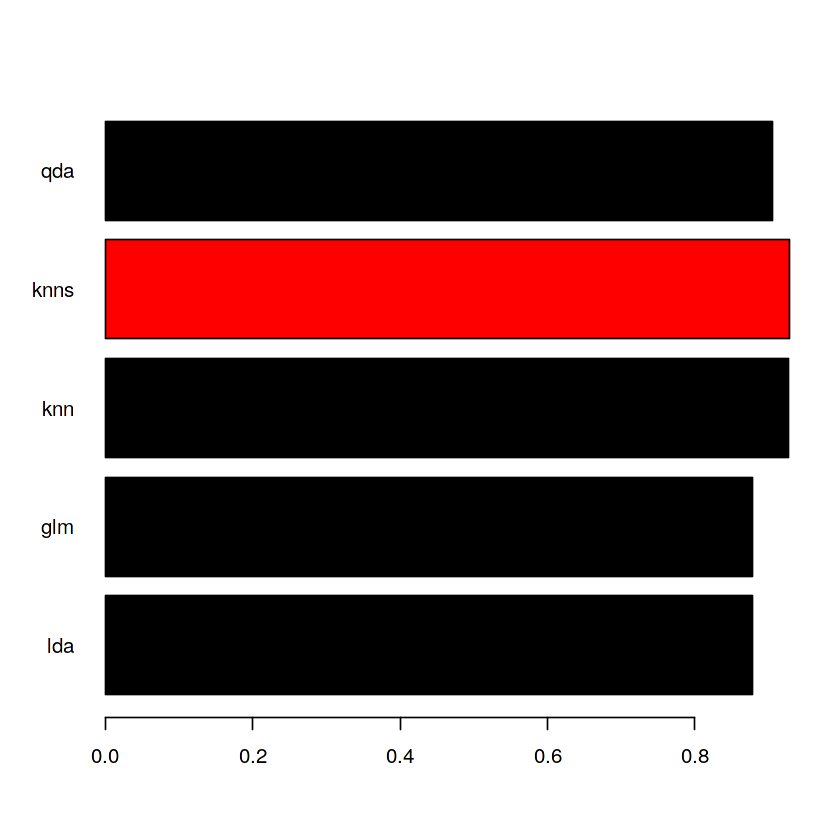

In [156]:
## Visualize model performance differences for 
## voice-gender recognition classifiers

# Put all fitted models in a named list (if necessary 
# change the names to match the names you used to store 
# the models in.)
models = list(lda=fit_lda, glm = fit_glm, knn=fit_knn, knns=fit_knns, qda=fit_qda) 

# extract the cross-validated accuracies from each model
Acc = sapply(models, function(mdl) max(mdl$results$Accuracy)) 

             
# make a barplot with only the best performing model in red
color = 1 + (Acc >= max(Acc)) 
barplot(Acc, horiz=T, las=1, col = color)

# 6.2 Statistical Comparison

To test if the performance differences between the models are statistically significant, and therefore real, you can conduct a [McNemar test](https://en.wikipedia.org/wiki/McNemar%27s_test). This is a Chi-square version of the paired t-test, for contingency tables.

We will use the `pairwise.table` function from R to conduct pairwise comparisons

In [163]:
## Test significance of classifier accuracy differences

# For each model in models compute a predicted label 
preds = sapply(models, predict)  # for each model, a columns of prediction 

# For each prediction, test if the prediction is correct
correct = (preds == voice$label) # matrix of TRUE and FALSE

# For pairwise.table() we need to define a function that returns the p-values
compare_func = function(i,j) mcnemar.test(correct[,i], correct[,j])$p.value

# Compute the table of pairwise comparisons
options(digits=3)
#print(zapsmall(pairwise.table(compare_func, level.names = colnames(preds), "none")))

       lda glm   knn knns
glm  0.134  NA    NA   NA
knn  0.000   0    NA   NA
knns 0.000   0 0.583   NA
qda  0.000   0 0.000    0


<span style=font-size:16pt>🧠</span> Draw some conclusions: 
- $\Rightarrow$ Is the best performer significantly better than the others?
- $\Rightarrow$ Is the best performer above or below our Bayes lower bound?
- $\Rightarrow$ Explain why these results lead you to conclude that non-linearity (including interactions between features) does not appear to play a performance limiting role for these features.

<details>
    <summary>Answers</summary>
    <ul>
        <li> Is the best performer significantly better than the others? <br />
            <em>Yes. The best performer is the logistic regression, and it has the highest accuracy. The McNemar test
                is significant for all comparisons with the logistic regression model and hence, it classifies better.
            </em>
        </li>
        <li> Is the best performer above or below the Bayes lower bound?<br />
            <em>Below. The Bayes lower bound that we found from researching the literature is 99% or so, which is well
                above even our best classifier.
            </em>
        </li>
        <li> Explain why these results leads you to conclude that non-linearity does not appear to play a 
            performance limiting role for these features. <br />
            <em>
                Both QDA and k-NN allow for non-linear decision boundaries. Neither of these increase the performance
                over the models with linear decision boundaries (logistic regression and LDA). Hence, non-linearity
                doesn't appear to be a limiting factor in model performance. 
            </em>
        </li>
    </ul>
</details>

<br />
<br />
<br />

---

<br />
<br />
<br />

<div style="line-height: 1.85em; font-size:larger; color: darkblue; border: 2px solid #eee;padding: 3px">Make sure all your code runs and shows output. Then click the <div style="display:inline-block;font-size: smaller; background-color: black; border-radius: 18px; color: white; padding-left: 6px"><span style="border-right:1px solid white;padding-right:8px;"> <i class="rmwc-icon rmwc-icon--ligature google-material-icons sc-gKXOVf iXgWvr">⟳</i> Save Version</span><span style="padding-left:6px;padding-right:6px">&nbsp;0&nbsp;</span></div> button and make sure that you select the  "Save &amp; Run All (Commit)" option in the pop-up window before you click Save button. Share your notebook and submit the URL to your notebook.

# <span style=font-size:16pt>🧠🧠🦾🦾</span> Extra: Sonar Signals

If you have time left build a classifier for a mine detection device. The `mlbench` package has a data set called `Sonar`. You can get more information about the data set with `help(Sonar)`.

In [ ]:
library(mlbench)
data(Sonar)

The features are the energy (the power) within particular frequency bands (STFT features aluded too earlier). Use these data do everything we did for the `voice` data set.


- Data origin (representative for which population?)
- What are candidate machine learning algorithms?
- What’s the Bayes bound?
- Your turn: what’s the best model?

If you run the code cell under **Answer Sonar** below, you will get answers and example code.

In [ ]:
## Sonar classifiers

# ... your code ...

#

## Answer Sonar

In [ ]:
cat("Type Yes to see the solution: "); ans = readline(); if (ans == "Yes") IRdisplay::display_markdown(RCurl::base64Decode("CmBgYAojIyBTb25hciBjbGFzc2lmaWVycwoKIyMgVGhyZWUgRnVuZGFtZW50YWwgUXVlc3Rpb25zCgojIDEpIFNlZSBoZWxwKFNvbmFyKSwgdGhlIHJlZmVyZW5jZSBHb3JtYW4gJiBTZWpub3dza2kgdGhlcmVpbiBzdGF0ZSAiVGhlIAojICAgIGRhdGEgdXNlZCBmb3IgdGhlIG5ldHdvcmsgZXhwZXJpbWVudHMgd2VyZSBzb25hciByZXR1cm5zIGNvbGxlY3RlZCAKIyAgICBmcm9tIGEgbWV0YWwgY3lsaW5kZXIgYW5kIGEgY3lsaW5kcmljYWxseSBzaGFwZWQgcm9jayBwb3NpdGlvbmVkIG9uIAojICAgIGEgc2FuZHkgb2NlYW4gZmxvb3IuIiBTbyB0aGVzZSBkYXRhIGFyZSB2YWxpZCBmb3IgdGhpcyBzaW5nbGUgcGFpciBvZiAKIyAgICByb2NrIGFuZCBjeWxpbmRlciBhbmQgZ2VuZXJhbGl6YWJpbGl0eSB0byBvdGhlciByb2Nrcy9jeWxpbmRlcnMgaXMgdW5jZXJ0YWluLgojIDIpIEFueSBjbGFzc2lmaWVyIGFsZ29yaXRobSAoZS5nLiwgTFIsIExEQSwgUURBLCBrTk4pCiMgMykgR29ybWFuICYgU2Vqbm93c2tpIHN0YXRlIGh1bWFuIGFjY3VyYWN5IG9mIDkwJSwgc2ltaWxhciB0byB0aGVpciBuZXVyYWwgCiMgICAgbmV0d29yawoKIyBDbGVhbiB1cApuenYgPSBuZWFyWmVyb1ZhcihTb25hclssIC02MV0pCmhpZ2hfY29yciA9IGNvcihTb25hclssIC02MV0pICU+JSBmaW5kQ29ycmVsYXRpb24oMC45KQpoaWdoX2NvcnIKY2xlYW5fc29uYXIgPSBTb25hclssIC1jKG56diwgaGlnaF9jb3JyKV0KCiMgQ2hvb3NlIHRyYWluQ29udHJvbCBzZXR0aW5ncwp0cmNudHIgPSB0cmFpbkNvbnRyb2woImN2IiwgbnVtYmVyID0gMiwgcCA9IC44KQoKIyBGaXQgdGhlIG1vZGVscyAoUURBIHdvbid0IGZpdCBiZWNhdXNlIG9mIHRoZSBzbWFsbCBzYW1wbGUgc2l6ZXMpCm1ldGhvZHMgPSBjKCJnbG0iLCAibGRhIiwgImtubiIpCnNvbmFyX2ZpdHMgPSBsYXBwbHkobWV0aG9kcywgZnVuY3Rpb24obWV0aG9kKSB0cmFpbihDbGFzcyB+IC4sIGRhdGE9Y2xlYW5fc29uYXIsIG1ldGhvZD1tZXRob2QsIHRyQ29udHJvbD10cmNudHIsIHByZVByb2Nlc3M9InNjYWxlIikpCm5hbWVzKHNvbmFyX2ZpdHMpID0gbWV0aG9kcwpzb25hcl9maXRzCgojIEV4dHJhY3QgY3Jvc3MtdmFsaWRhdGVkIGFjY3VyYWNpZXMKQWNjID0gc2FwcGx5KHNvbmFyX2ZpdHMsIGZ1bmN0aW9uKG1kbCkgbWF4KG1kbCRyZXN1bHRzJEFjY3VyYWN5KSkgCgojIE1ha2UgYSBiYXJwbG90IHdpdGggb25seSB0aGUgYmVzdCBwZXJmb3JtaW5nIG1vZGVsIGluIHJlZApiYXJwbG90KEFjYywgaG9yaXo9VCwgbGFzPTEsIGNvbCA9IDEgKyAoQWNjID49IG1heChBY2MpKSkKICAgICAgICAgICAgIAojIFRlc3QgcGVyZm9ybWFuY2UgZGlmZmVyZW5jZXMKcHJlZHMgPSBzYXBwbHkoc29uYXJfZml0cywgcHJlZGljdCkgPT0gY2xlYW5fc29uYXIkQ2xhc3MKY29tcGFyZV9mdW5jID0gZnVuY3Rpb24oaSxqKSBtY25lbWFyLnRlc3QocHJlZHNbLGldLCBwcmVkc1ssal0pJHAudmFsdWUKcGFpcndpc2UudGFibGUoY29tcGFyZV9mdW5jLCBsZXZlbC5uYW1lcyA9IGNvbG5hbWVzKHByZWRzKSwgIm5vbmUiKQoKYGBgCg=="))